# Read Data

In [2]:
import pandas as pd
from pyathena.util import as_pandas
from datetime import datetime
import numpy as np
import functools as ft
import os
from constants import TREE, PROJ_DIR
from typing import List, Set, Dict, Tuple
from utils import get_conn, ICDDataset, probs_to_preds
from icd9.icd9 import ICD9, Node

In [24]:
# read in raw data
subdir = "full_data"
roots_df = pd.read_csv(os.path.join(subdir, "roots.csv"))
notes_df = pd.read_csv(os.path.join(subdir, "notes.csv"))

In [29]:
# join icd roots with notes
df = roots_df.merge(notes_df, on="hadm_id", how="inner").dropna()

In [61]:
# group the data by admission id
model_df = df.groupby("hadm_id").aggregate(lambda x: list(set(x)))\
           .reset_index()\
           .loc[:, ["roots", "tokens"]]
model_df["tokens"] = model_df["tokens"].apply(lambda x: x[0])

# Exploratory Visualizations

In [6]:
from visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns

## Summary Table

In [429]:
summary_table = pd.read_csv("data/full_summary.csv")

In [430]:
summary_table.columns = ["Category"] + list(summary_table.columns[1:])
summary_table = summary_table.set_index("Category")

In [435]:
summary_table.astype("int")

,Totals,Male,Medicare,Female,Private,Medicaid,Government,Self Pay
Category,,,,,,,,
Patients,46520,26121,21002,20399,19663,4570,1614,600
Admissions,58976,32950,28215,26026,22582,5785,1783,611
ICD9 Codes,11501,5852,5023,5649,5718,3989,2657,1467
Deaths,5836,3141,3903,2695,1372,381,90,95
Admissions Per Patient,1,1,1,1,1,1,1,1
ICD9 Codes Per Patient,0,0,0,0,0,0,1,2
ICD9 Codes Per Admission,0,0,0,0,0,0,1,2
Death Per Patient,0,0,0,0,0,0,0,0


In [432]:
icd_table = pd.read_csv("data/icd_summary.csv")

In [433]:
icd_table = icd_table.sort_values("Mimic-iii Counts", ascending=False)
icd_latex = icd_table.to_latex()

In [434]:
icd_table

,Code,Description,Mimic-iii Counts,Nodes in ICD Tree
2,390-459,DISEASES OF THE CIRCULATORY SYSTEM,124782,516
3,240-279,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES,...",52095,333
0,460-519,DISEASES OF THE RESPIRATORY SYSTEM,40989,277
11,800-999,INJURY AND POISONING,35518,1881
5,520-579,DISEASES OF THE DIGESTIVE SYSTEM,34595,625
1,580-629,DISEASES OF THE GENITOURINARY SYSTEM,32860,471
8,780-799,"SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS",28873,372
6,320-389,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS,20397,1633
15,001-139,INFECTIOUS AND PARASITIC DISEASES,19507,1057
13,V10-V19,PERSONS WITH POTENTIAL HEALTH HAZARDS RELATED ...,18358,228


## Category Counts

In [36]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

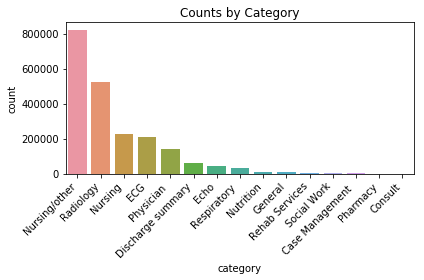

In [39]:
cat_fp = os.path.join(PROJ_DIR, "images", "categories.png")
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distribution of ICD Codes in Note

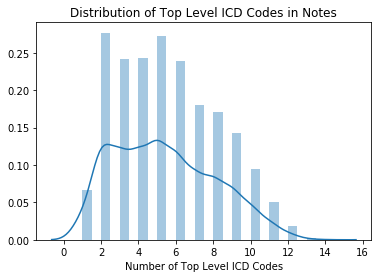

In [47]:
lens = [len(r) for r in model_df["roots"].tolist()]
ax = sns.distplot(lens)
ax.set(xlabel="Number of Top Level ICD Codes",
       title="Distribution of Top Level ICD Codes in Notes")
plt.savefig("images/num_icd_codes.png")
plt.show()

## Distribution of Word Counts in Notes

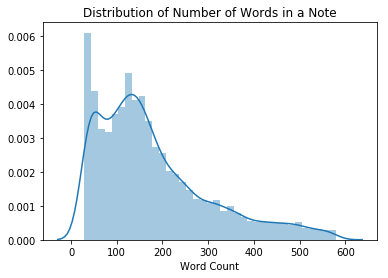

In [376]:
with get_conn() as conn:
    cursor = conn.cursor()
    notes = as_pandas(cursor.execute("select text from mimiciii.noteevents order by RAND() limit 10000;"))["text"]
lens = notes.apply(lambda x: len(x.split()))
no_outliers = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]
ax = sns.distplot(no_outliers)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig("images/word_counts.png")
plt.show()

## ICD Codes by Insurance

In [413]:
# read data
with get_conn() as conn:
    cursor = conn.cursor()
    query = """
    select admissions.hadm_id as adm_id, count(diagnoses_icd.icd9_code) as icd, array_agg(admissions.insurance)[1] as insurance
    from mimiciii.admissions as admissions
    join mimiciii.diagnoses_icd as diagnoses_icd
    on admissions.hadm_id = diagnoses_icd.hadm_id
    group by admissions.hadm_id;
    """
    insur_icd_df = as_pandas(cursor.execute(query))

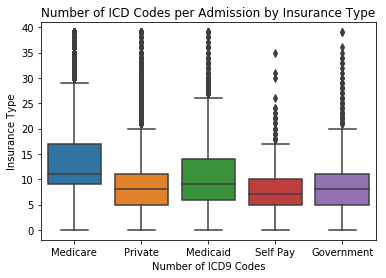

In [603]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig("images/insurance.png")
plt.show()

# Embedding

## Word2Vec

In [9]:
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

In [12]:
# load word2vec embeddings
w2v_fp = os.path.join(PROJ_DIR, "embeddings", "GoogleNews-vectors-negative300.bin")
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

In [67]:
# embed with word2vec
model_df["w2v"] = model_df["tokens"].apply(lambda note: [word2vec[t] for t in note if t in word2vec])

In [68]:
emb_lens = [len(d) for d in model_df["w2v"].tolist()]

## BERT

In [651]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Models

## Prepare Data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [73]:
# combine word embeddings
model_df["d2v"] = model_df["w2v"].apply(lambda x: np.mean(x, axis=0))

In [78]:
# one hot encode roots
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(model_df["roots"])
class_names = mlb.classes_

# extract combined word embeddings
X = np.array(model_df["d2v"].tolist())

# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

## Baseline Models

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [86]:
# instantiate classifiers
clfs = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(multi_class="ovr")),
    "RandomForest": OneVsRestClassifier(RandomForestClassifier(n_estimators=150, criterion="entropy")),
    "MultiLayerPerceptron": MLPClassifier(hidden_layer_sizes=(40, 30))
}

In [87]:
# train baseline classifiers
trained_clfs = {name: clf.fit(X_train, Y_train) for name, clf in clfs.items()}

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [407]:
class LSTM(nn.Module):
    """An LSTM implementation."""

    def __init__(self, n_feat, h_size, lstm_size, n_cat):
        super(LSTM, self).__init__()
        # define layers
        self.lstm = nn.LSTM(h_size, lstm_size, batch_first=True)
        self.h = nn.Linear(n_feat, h_size)
        self.out = nn.Linear(lstm_size, n_cat)
        self.sig = nn.Sigmoid()

    def forward(self, X):
        lstm = F.relu(self.lstm(X))
        hidden = F.relu(self.h(lstm))
        output = self.sig(self.out(hidden))
        return output
    
    def run_train(self, trainloader: DataLoader, n_epochs: int) -> None:
        """Train network on training set."""
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        # loop over the dataset for each epoch
        print("Training mlp .....")
        for i in range(n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for data in trainloader:
                # extracts features/labels from loader
                feats, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # retrieve outputs
                breakpoint()
                outputs = self.forward(feats.unsqueeze(0))
                
                # determine loss and backprop
                loss = loss_fn(outputs, labels)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters
                
            print(f"loss = {loss}")
        print("done.")

In [405]:
# declare train and test loaders
BATCH_SIZE = 64
trainset = ICDDataset(emb_train, np.array(Y_train))
testset = ICDDataset(X_test, np.array(Y_test))
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, shuffle=False)

In [408]:
# train MLP
n_epochs = 30
n_feats = trainset.X.shape[1]
n_cats = len(top_level_roots)
lstm = LSTM(n_feats, 50, 35, n_cats)
lstm.run_train(trainloader, n_epochs)

Training mlp .....
	Epoch 0: > <ipython-input-407-63de4d7b9305>(36)run_train()
-> outputs = self.forward(feats.unsqueeze(0))


(Pdb)  feats


tensor([[-0.6701, -0.4250,  0.2361,  ...,  0.1179, -0.1573,  0.0930],
        [-2.6161, -0.3542, -0.1131,  ...,  0.6816, -0.5644,  0.8088],
        [-0.8327, -0.2718,  0.3239,  ..., -0.3349,  0.0167, -0.0646],
        ...,
        [ 0.2721, -0.6895, -0.2552,  ...,  0.2014, -2.1652,  2.1458],
        [-1.1545, -1.2734,  0.7485,  ..., -2.3777, -0.7547,  0.1417],
        [-0.8845, -0.5813,  0.4892,  ..., -0.2053, -0.6622,  0.1400]])


(Pdb)  feats.shape


torch.Size([64, 50])
--KeyboardInterrupt--


(Pdb)  quit()


Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


BdbQuit: 

(Pdb)  quit()


# Results

In [88]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, precision_recall_curve)

In [89]:
# store prediction and probability results
pred_clfs = {name: clf.predict(X_test) for name, clf in trained_clfs.items()}
prob_clfs = {name: clf.predict_proba(X_test) for name, clf in trained_clfs.items()}

## Performance Results

In [90]:
# get performance data
f1s = [f1_score(Y_test, preds, average="weighted", zero_division=1) for preds in pred_clfs.values()]
accs = [accuracy_score(Y_test, preds) for preds in pred_clfs.values()]
metrics = f1s + accs
met_labels = ["F1 Score"] * len(pred_clfs) + ["Accuracy"] * len(pred_clfs)
clf_names = list(pred_clfs.keys()) * 2

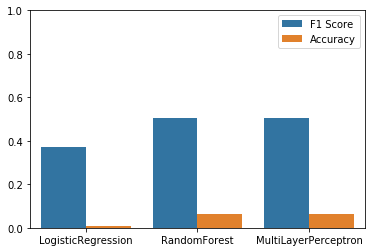

In [91]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
plt.show()

## Classification Reports

In [92]:
class_reports = {name: classification_report(Y_test, Y_pred, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for name, Y_pred in pred_clfs.items()}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [93]:
crep_df

LogisticRegression                              \
                       f1-score precision    recall support   
001-139                0.000000  1.000000  0.000000   391.0   
140-239                0.000000  1.000000  0.000000   135.0   
240-279                0.697939  0.611457  0.812914   604.0   
290-319                0.000000  1.000000  0.000000   244.0   
320-389                0.000000  1.000000  0.000000   345.0   
390-459                0.832298  0.714667  0.996283   807.0   
460-519                0.741678  0.663886  0.840121   663.0   
520-579                0.000000  0.000000  0.000000   459.0   
580-629                0.112150  0.491803  0.063291   474.0   
630-679                1.000000  1.000000  1.000000     0.0   
680-709                0.000000  1.000000  0.000000   171.0   
710-739                0.000000  1.000000  0.000000   153.0   
760-779                0.072727  0.888889  0.037915   211.0   
780-799                0.013216  0.750000  0.006667   450.0   
800-999                0.422170  0.549080  0.342912   522.0   
V01-V91                0.703898  0.558118  0.952756   635.0   
micro avg              0.509129  0.629586  0.427363  6264.0   
macro avg              0.287255  0.764244  0.315804  6264.0   
weighted avg           0.371448  0.674394  0.427363  6264.0   
samples avg            0.491747  0.626555  0.448930  6264.0   

             MultiLayerPerceptron                             RandomForest  \
                         f1-score precision    recall support     f1-score   
001-139                  0.043478  0.391304  0.023018   391.0     0.215569   
140-239                  0.000000  1.000000  0.000000   135.0     0.000000   
240-279                  0.722372  0.609091  0.887417   604.0     0.713972   
290-319                  0.000000  1.000000  0.000000   244.0     0.076336   
320-389                  0.000000  1.000000  0.000000   345.0     0.108247   
390-459                  0.874224  0.802277  0.960347   807.0     0.866328   
460-519                  0.752604  0.662085  0.871795   663.0     0.719713   
520-579                  0.281553  0.547170  0.189542   459.0     0.327965   
580-629                  0.550049  0.509910  0.597046   474.0     0.495413   
630-679                  1.000000  1.000000  1.000000     0.0     1.000000   
680-709                  0.000000  1.000000  0.000000   171.0     0.011494   
710-739                  0.000000  1.000000  0.000000   153.0     0.000000   
760-779                  0.747312  0.863354  0.658768   211.0     0.735376   
780-799                  0.410811  0.524138  0.337778   450.0     0.358543   
800-999                  0.627677  0.550578  0.729885   522.0     0.553148   
V01-V91                  0.695018  0.565776  0.900787   635.0     0.683959   
micro avg                0.591545  0.626025  0.560664  6264.0     0.571097   
macro avg                0.419069  0.751605  0.447274  6264.0     0.429129   
weighted avg             0.504354  0.672548  0.560664  6264.0     0.506815   
samples avg              0.580564  0.644699  0.593338  6264.0     0.556021   

                                          
             precision    recall support  
001-139       0.490909  0.138107   391.0  
140-239       1.000000  0.000000   135.0  
240-279       0.639581  0.807947   604.0  
290-319       0.555556  0.040984   244.0  
320-389       0.488372  0.060870   345.0  
390-459       0.795031  0.951673   807.0  
460-519       0.685792  0.757164   663.0  
520-579       0.500000  0.244009   459.0  
580-629       0.542714  0.455696   474.0  
630-679       1.000000  1.000000     0.0  
680-709       0.333333  0.005848   171.0  
710-739       1.000000  0.000000   153.0  
760-779       0.891892  0.625592   211.0  
780-799       0.484848  0.284444   450.0  
800-999       0.599553  0.513410   522.0  
V01-V91       0.603614  0.788976   635.0  
micro avg     0.647190  0.511015  6264.0  
macro avg     0.663200  0.417170  6264.0  
weighted avg  0.624672  0.511015  6264.0  
sample

## Probability Distributions

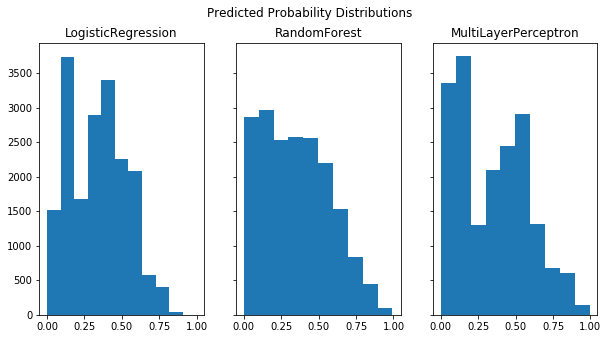

In [94]:
fig, axs = plt.subplots(1, len(prob_clfs), sharey="all", sharex="all")
for ax, name, probs in zip(axs, prob_clfs.keys(), prob_clfs.values()):
    ax.hist(probs.flatten())
    ax.set(title=name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.show()

## Precision/Recall Curves

In [95]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in thresholds:
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [96]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 100)
pr_dfs = [pr_curve(name, probs, Y_test, thresholds) for name, probs in prob_clfs.items()]
pr_df = pd.concat(pr_dfs)

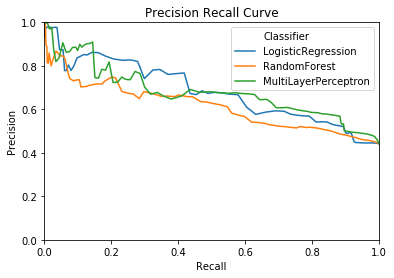

In [97]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.show()

## Category Performance

In [366]:
# read in data
with get_conn() as conn:
    cursor = conn.cursor()
    query = f"""
    SELECT
      row_id as row_id,
      category
    FROM
      mimiciii.noteevents;
    """
    cat_df = as_pandas(cursor.execute(query))

In [377]:
cat_df.head()

,row_id,category
0,20030,Discharge summary
1,20031,Discharge summary
2,20032,Discharge summary
3,20033,Discharge summary
4,20034,Discharge summary


In [ ]:
merged_df = cat_df.merge(pd.DataFrame({"accaccs))